In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from env import get_db_url
import acquire
import prepare


# Explore data (on train only)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df = prepare.prep_zillow(df)

In [4]:
df.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,assessed_value,tax_value,transaction_date,log_error,transaction_month,county
5,3,2.0,1222,5500,1,96193,1951,33889894.0,-118100732.0,6037,290492,3870,2017-01-03,-0.316484,01,Los Angeles
38,4,2.5,1620,8531,1,97099,1967,34440918.0,-119293909.0,6111,369463,4585,2017-01-03,0.102849,01,Ventura
40,4,4.0,2840,60548,1,97099,1966,34452715.0,-119266845.0,6111,610795,6970,2017-01-03,-0.069136,01,Ventura
54,3,2.0,1638,197651,1,97099,1989,34454777.0,-119197226.0,6111,653582,6997,2017-01-03,-0.010887,01,Ventura
58,3,2.0,1583,8000,1,97099,1961,34419017.0,-119296402.0,6111,465462,5644,2017-01-03,0.052558,01,Ventura


In [5]:
df.shape

(8303, 16)

In [6]:
train_validate, test = train_test_split(df, test_size = 0.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size = 0.20, random_state = 123)
print(train.shape, validate.shape, test.shape)

(5977, 16) (1495, 16) (831, 16)


In [7]:
train.shape

(5977, 16)

<AxesSubplot:xlabel='transaction_month', ylabel='tax_value'>

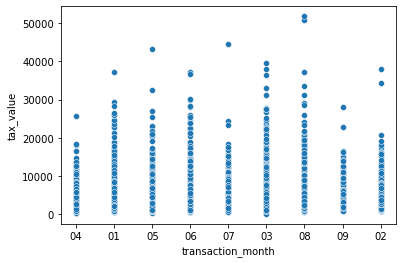

In [8]:
sns.scatterplot(x=train.transaction_month, y=train.tax_value)

In [9]:
#discrete columns
discrete = [col for col in [col for col in train.columns if train[col].dtypes in ['int64','float64']] if 'sqft' not in col and  'cnt' not in col and  'nbr' not in col and 'number' not in col and len(train[col].unique())< 50  ]
print('we have {} columns of discrete variables which are columns with unique values less than 50'.format(len(discrete)))

we have 4 columns of discrete variables which are columns with unique values less than 50


In [10]:
#continuous columns
continuous = [col for col in [col for col in train.columns if train[col].dtypes in ['int64','float64']] if col not in discrete]
print('we have {} columns of continuous variable which are columns with unique values more than 50'.format(len(continuous)))

we have 9 columns of continuous variable which are columns with unique values more than 50


In [11]:
#function to plot parameter values in graph
## modify version from https://www.analyticsvidhya.com/blog/2021/06/eda-exploratory-data-analysis-with-python/
def univariate(data,col,vartype=[0,1],hue =None):    
    '''
    Univariate function will plot parameter values in graphs.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuous or categorical
                Continuous(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : Only applicable in categorical analysis.
    '''
    sns.set(style="darkgrid")
    df = data.copy()
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=5,figsize=(20,6))
        #
        ax[0].set_title(col+" Distribution Plot")
        sns.distplot(df[col],ax=ax[0])

        ax[1].set_title(col+" Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")#.set(ylabel='')
        #
        ax[2].set_title(col+" Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
        #
        ax[3].set_title(col+" strip Plot")
        sns.stripplot(data =df, x=col,ax=ax[3])
        df[col]=np.log(df[col])
        ax[4].set_title(col+" scatter Plot")
        sns.scatterplot(x =df[col], y=df['logerror'],ax=ax[4])

        

    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
      
        width = len(df[col].unique()) + 3 + 2*len(temp.unique())
        fig.set_size_inches(width , 4)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+10))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.16, p.get_height()+10)) 
        del temp
    else:
        exit
    fig.tight_layout()
    plt.show()

In [12]:
#for col in train[continuous].columns:
  #univariate(train,col,0,hue =None)

In [13]:
discrete = [ col for col in discrete if train[col].nunique()>1]

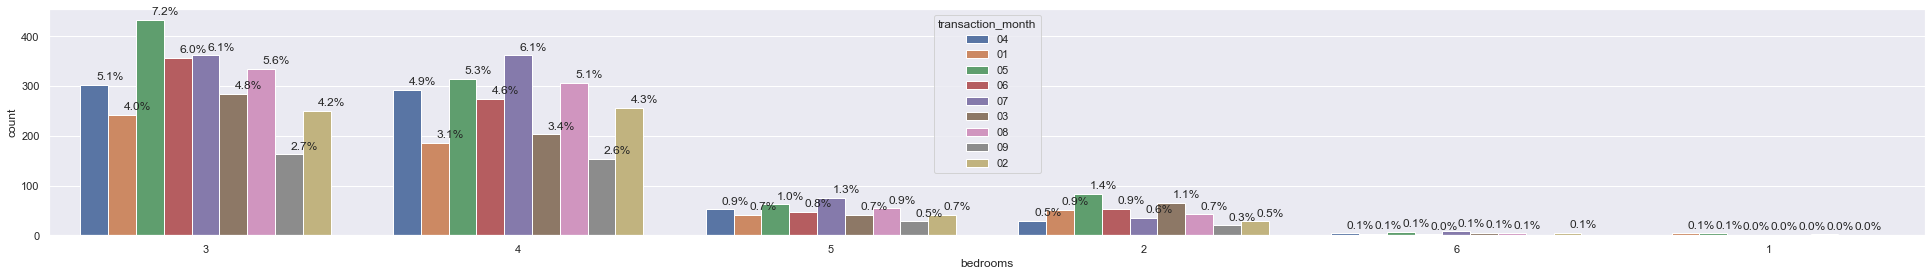

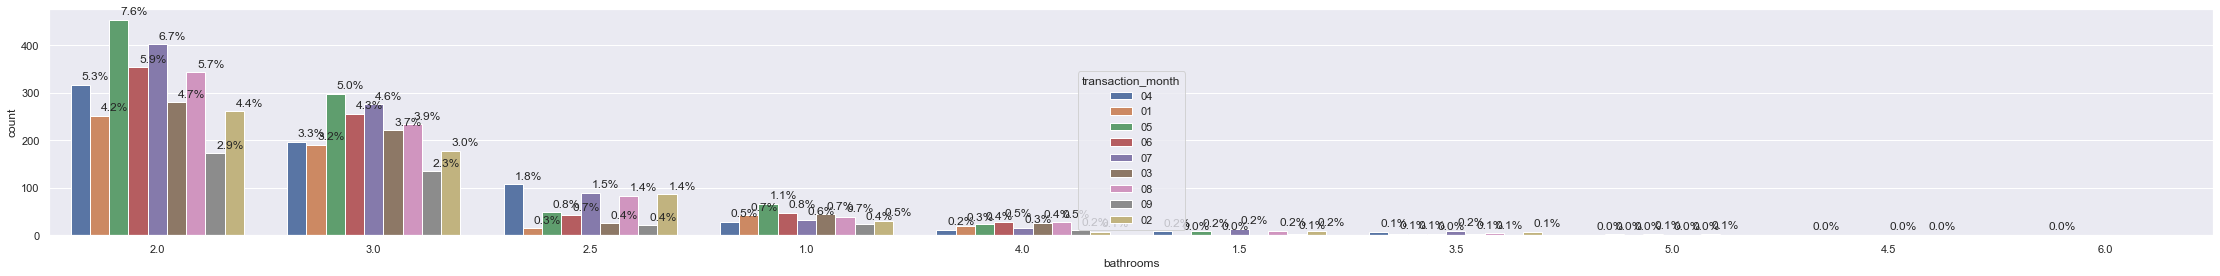

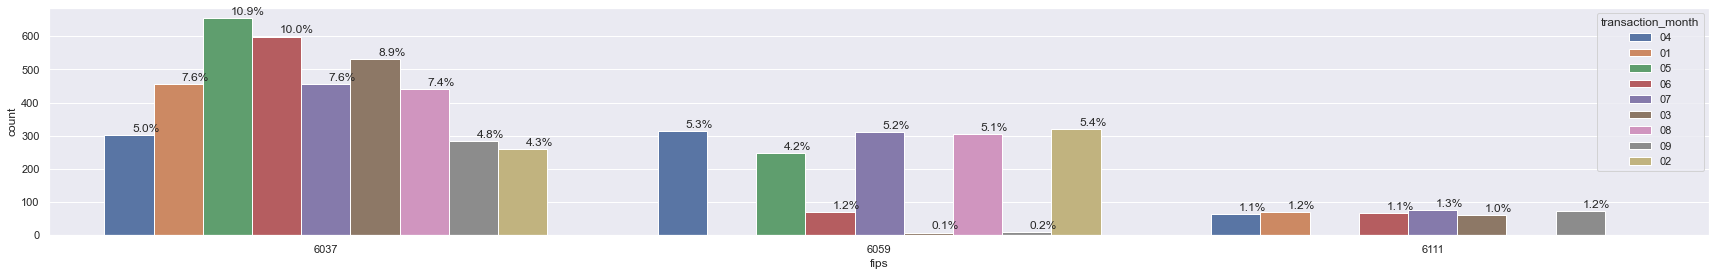

In [14]:
for col in train[discrete].columns:
  univariate(train,col,1,hue =train.transaction_month)

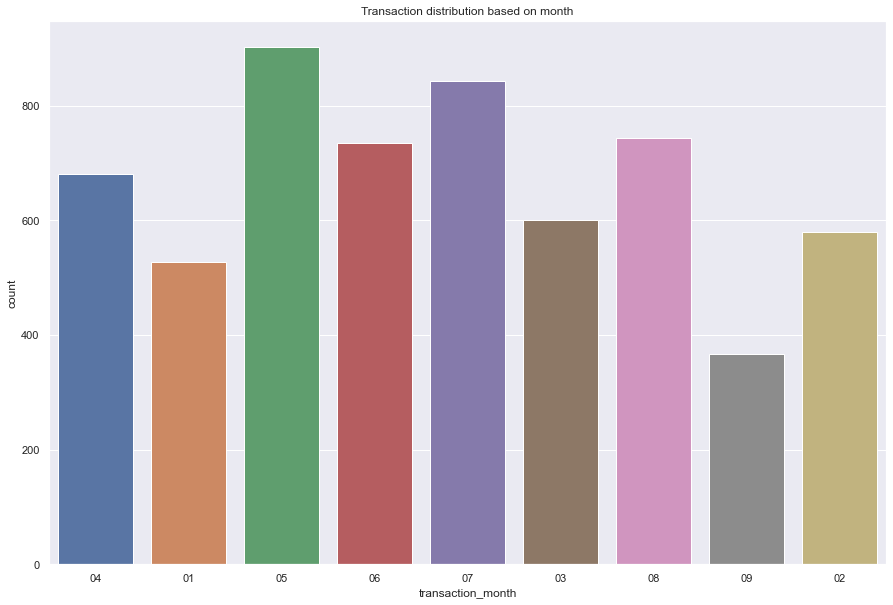

In [15]:
#Temporal data distribution
plt.figure(figsize=(15,10))
sns.countplot(x=train.transaction_month).set_title("Transaction distribution based on month");

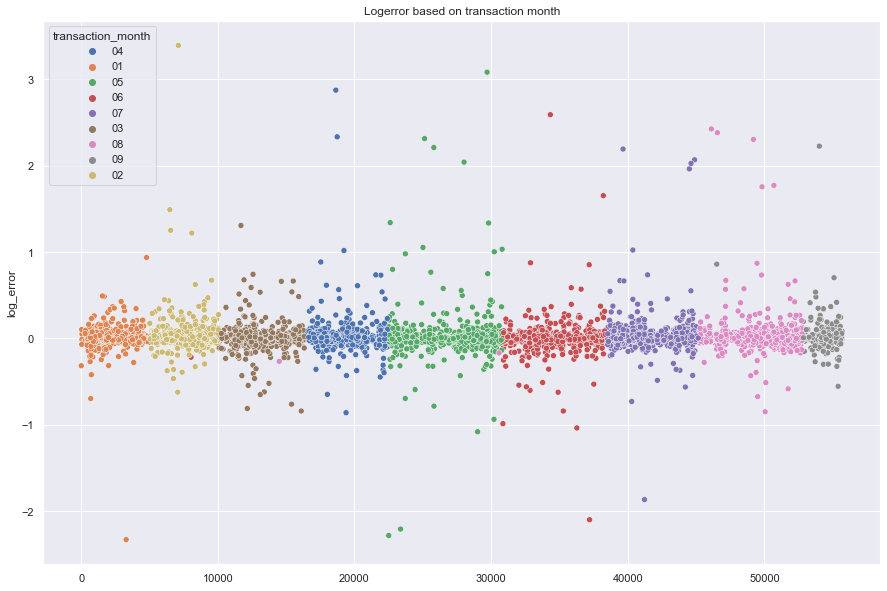

In [16]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=train.index,y=train.log_error,hue=train.transaction_month).set_title("Logerror based on transaction month");

In [17]:
categorical = [col for col in train.columns if train[col].dtypes  in ['object'] ]
categorical

['transaction_date', 'transaction_month', 'county']

In [18]:
train.columns

Index(['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'pool', 'zip_code',
       'year_built', 'latitude', 'longitude', 'fips', 'assessed_value',
       'tax_value', 'transaction_date', 'log_error', 'transaction_month',
       'county'],
      dtype='object')

In [19]:
train['county'].unique()

array(['Los Angeles', 'Orange', 'Ventura'], dtype=object)

In [20]:
train.head()

,bedrooms,bathrooms,square_feet,lot_size,pool,zip_code,year_built,latitude,longitude,fips,assessed_value,tax_value,transaction_date,log_error,transaction_month,county
22179,4,2.0,1924,7456,1,96336,1975,34164939.0,-118748585.0,6037,596053,6986,2017-04-28,0.029118,04,Los Angeles
777,4,2.0,2165,11336,1,96342,1966,34193539.0,-118659024.0,6037,343798,4169,2017-01-06,0.004688,01,Los Angeles
19657,3,2.0,1873,8343,1,97079,1983,33886150.0,-117764068.0,6059,278125,3163,2017-04-14,-0.010182,04,Orange
25788,3,3.0,1485,7675,1,96265,1931,34197437.0,-118150547.0,6037,569542,6744,2017-05-15,0.279324,05,Los Angeles
22681,3,3.0,2178,14551,1,96027,1951,34123534.0,-118377602.0,6037,1290000,15690,2017-05-01,0.006949,05,Los Angeles


for i, predictor in enumerate(train.drop(columns=['transaction_date','zip_code','latitude','longitude','fips'])):
    plt.figure(i)
    sns.countplot(data=train, x=predictor, hue='transaction_month')

In [ ]:
categorical = [col for col in train.columns if train[col].dtypes  in ['object'] ]
categorical